In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import pathlib
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm_notebook as tqdm

In [3]:
from unet.data import loader

In [4]:
root = '/data/idcard/results/combined/segmentv3/20kv1/'
trainloader, trainset = loader.pair_data_loader(root_path=root, mode='train', batch_size=16)
validloader, validset = loader.pair_data_loader(root_path=root, mode='valid', batch_size=16)

In [5]:
from unet.models.unet import UNet
from unet.trainer.task import TaskUNet

model = UNet(in_chan=1, n_classes=1, start_feat=32)
model_state_dict = torch.load('weights/unet_sfeat32_v5.pth')
model.load_state_dict(model_state_dict)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
task = TaskUNet(model, optimizer, criterion)

In [6]:
torch.cuda.device_count()

1

In [7]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

# DEFAULTS used by the Trainer
SAVED_CHECKPOINT_PATH = 'checkpoints/'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=SAVED_CHECKPOINT_PATH,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='unetv3'
)

SAVED_LOGS_PATH = 'logs/'
tb_logger = pl_loggers.TensorBoardLogger(SAVED_LOGS_PATH)

trainer = pl.Trainer(
    weights_summary="top",
    max_epochs=3,
    val_check_interval=1000,
    gpus=-1,
    logger=tb_logger, 
    checkpoint_callback=checkpoint_callback, 
)

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /home/nunenuh/study/code/repo/unet.pytorch exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [89]:
# trainer.fit(task, trainloader, validloader)

In [9]:
state_dict = task.model.state_dict()
unet_path = 'weights/unet_sfeat32_v5.pth'
torch.save(state_dict, unet_path)

In [11]:
unet_path = 'weights/unet_sfeat32_v5.pth'
state_dict = torch.load(unet_path)
model = UNet(in_chan=1, n_classes=1, start_feat=32)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
imgs, mask = next(iter(validloader))
output = task.model(imgs)
output = torch.sigmoid(output)
output.shape

torch.Size([16, 1, 320, 320])

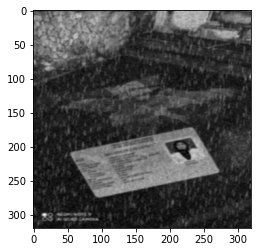

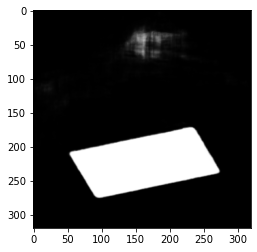

In [13]:
idx = 15
plt.imshow(imgs[idx].squeeze(), cmap='gray');plt.show()
plt.imshow(output[idx].squeeze().cpu().detach().numpy(), cmap='gray')

In [126]:
from unet.prod import SegmentationPredictor
unet_path = 'weights/unet_sfeat32_v4.pth'
segment = SegmentationPredictor(weight_path=unet_path)

In [169]:
# im_path = '/data/idcard/combined/1609935833/182_image.jpg'
im_path = '/data/idcard/fandi_ktp/ktp6.jpg'
# im_path = '/data/idcard/ktp_aan/ktp4.jpg'
image,mask,mask_bbox, combined, combined_bbox = segment.predict(im_path)

In [170]:
w,h = image.size

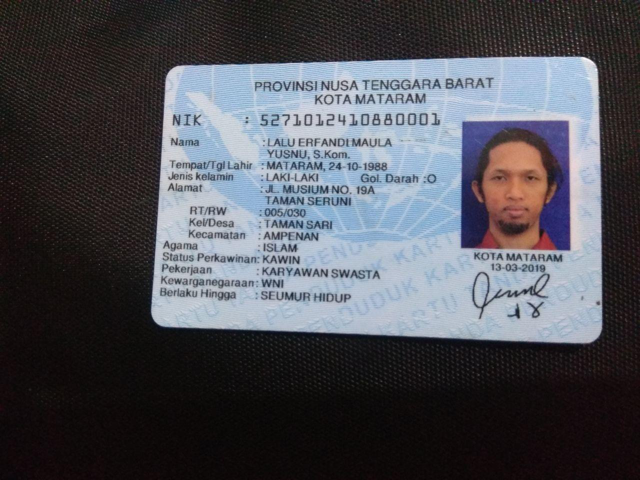

In [171]:
image.resize(size=(w//2,h//2))

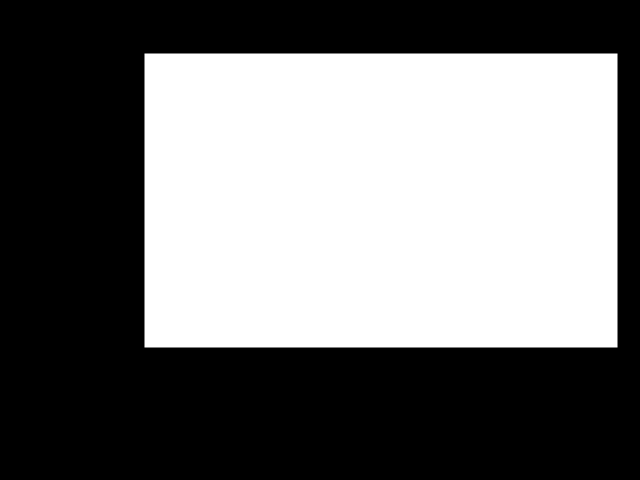

In [172]:
mask_bbox.resize(size=(w//2,h//2))

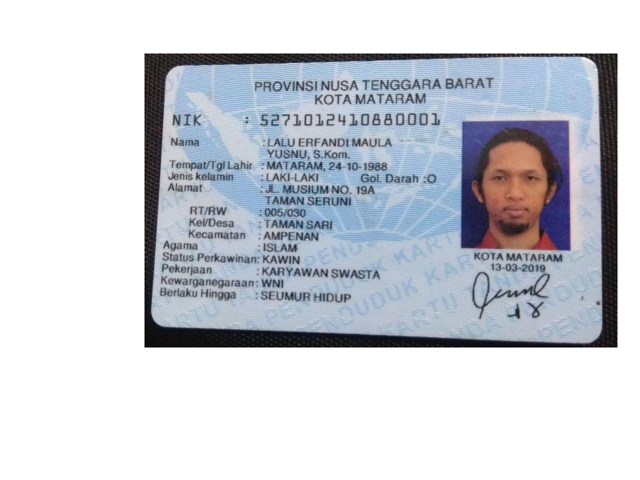

In [173]:
combined_bbox.resize(size=(w//2,h//2))

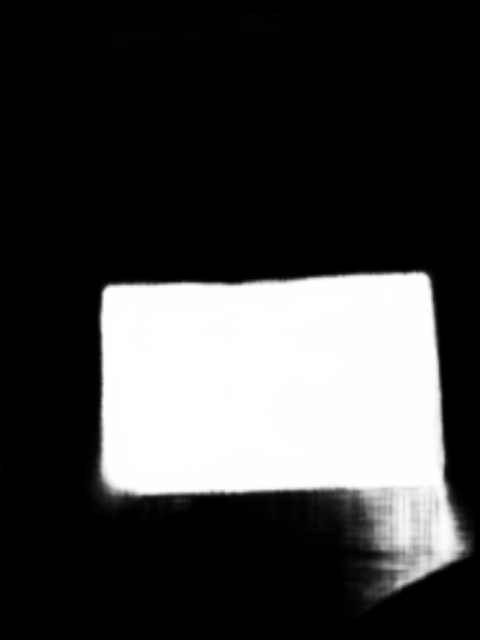

In [167]:
mask.resize(size=(w//2,h//2))

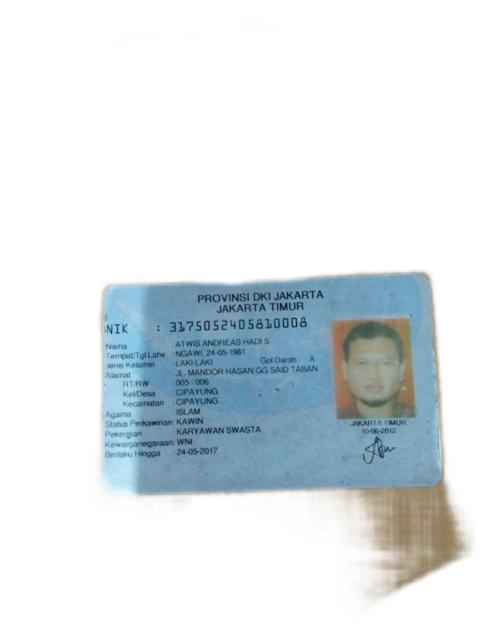

In [168]:
combined.resize(size=(w//2,h//2))

In [ ]:
plt.imshow(output, cmap='gray');plt.show()